# Chapter: Recurrent Neural Networks


# Topic: System Indentification of SISO Heater System

In [1]:
# import required packages
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

Text(0.5, 0, 'Time (sec)')

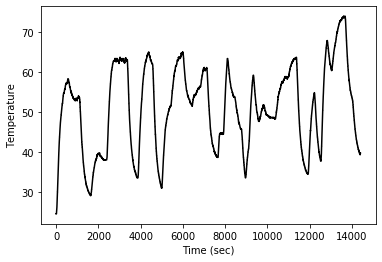

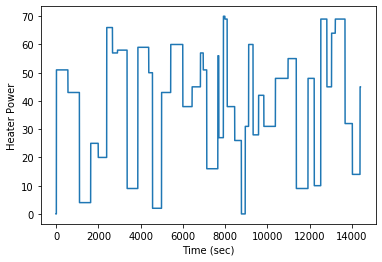

In [2]:
# read data
data = pd.read_csv('TCLab_train_data.txt')
heaterPower = data[['Q1']].values
temperature = data[['T1']].values

# plot data
plt.plot(temperature, 'k')
plt.ylabel('Temperature')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(heaterPower)
plt.ylabel('Heater Power')
plt.xlabel('Time (sec)')

In [4]:
# decide model input-outputs and scale data
from sklearn.preprocessing import StandardScaler

X = data[['T1','Q1']].values
y = data[['T1']].values

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          re-arrage data with time steps
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [5]:
# rearrange X data into (# sequence samples, # time steps, # features) form
nTimeSteps = 70
X_train_sequence = []
y_train_sequence = []

for sample in range(nTimeSteps, X_scaled.shape[0]):
    X_train_sequence.append(X_scaled[sample-nTimeSteps:sample,:])
    y_train_sequence.append(y_scaled[sample])

# X conversion: convert list of (time steps, features) arrays into (samples, time steps, features) array 
X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence) 

In [12]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          Define & Fit FFNN model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [6]:
#%% import Keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [8]:
# define model
model = Sequential()
model.add(LSTM(units=25, kernel_regularizer=regularizers.L1(0.001), input_shape=(nTimeSteps,2)))
model.add(Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                2800      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 2,826
Trainable params: 2,826
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile model
model.compile(loss='mse', optimizer='Adam')

In [10]:
# fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_sequence, y_train_sequence, epochs=100, batch_size=250, validation_split=0.3, callbacks=[es])


Epoch 1/100
41/41 [==============================] - 2s 38ms/step - loss: 0.1501 - val_loss: 0.0886
Epoch 2/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0319 - val_loss: 0.0721
Epoch 3/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0260 - val_loss: 0.0600
Epoch 4/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0224 - val_loss: 0.0527
Epoch 5/100
41/41 [==============================] - 1s 31ms/step - loss: 0.0195 - val_loss: 0.0458
Epoch 6/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0169 - val_loss: 0.0405
Epoch 7/100
41/41 [==============================] - 1s 30ms/step - loss: 0.0147 - val_loss: 0.0361
Epoch 8/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0127 - val_loss: 0.0315
Epoch 9/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0112 - val_loss: 0.0299
Epoch 10/100
41/41 [==============================] - 1s 28ms/step - loss: 0.0098 - val_loss: 0.0280

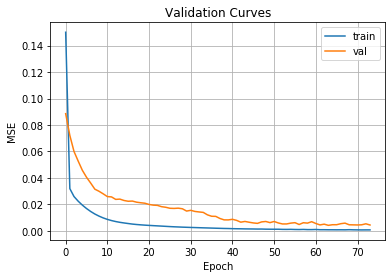

In [11]:
# plot validation curve
plt.figure()
plt.title('Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 1.0, 'Training data')

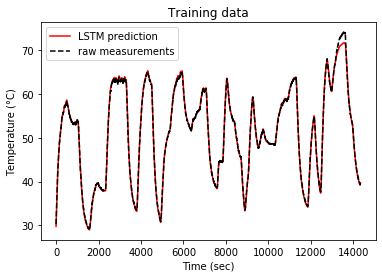

In [12]:
# check fit on training data
y_train_sequence_pred = model.predict(X_train_sequence) 
y_measured = y_scaler.inverse_transform(y_train_sequence)
y_pred =  y_scaler.inverse_transform(y_train_sequence_pred)

# plot
plt.figure()
plt.plot(y_pred, 'r-', label='LSTM prediction')
plt.plot(y_measured, 'k--', label='raw measurements')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Training data')

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         predict for test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [13]:
# read test data
data_test = pd.read_csv('TCLab_test_data.txt')
X_test = data_test[['T1','Q1']].values
y_test = data_test[['T1']].values

# scale data
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# re-arrange data into sequence form
X_test_sequence = []
y_test_sequence = []

for sample in range(nTimeSteps, X_test_scaled.shape[0]):
    X_test_sequence.append(X_test_scaled[sample-nTimeSteps:sample,:])
    y_test_sequence.append(y_test_scaled[sample])

X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)

Text(0.5, 0, 'Time (sec)')

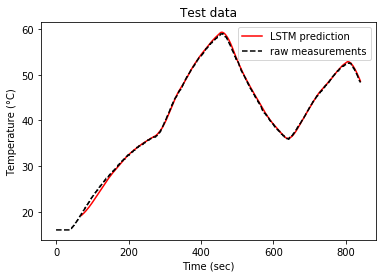

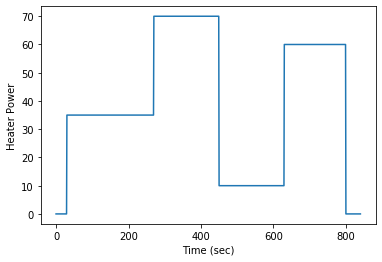

In [14]:
# predict y_test
y_test_sequence_pred = model.predict(X_test_sequence) 
y_test_pred =  y_scaler.inverse_transform(y_test_sequence_pred)

# plot
nRows_test = y_test.shape[0]

# temperature
plt.figure()
plt.plot(np.arange(nTimeSteps, nRows_test), y_test_pred, 'r-', label='LSTM prediction')
plt.plot(np.arange(nRows_test), y_test, 'k--', label='raw measurements')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Test data')

# heater power
plt.figure()
plt.plot(X_test[:,1])
plt.ylabel('Heater Power')
plt.xlabel('Time (sec)')